In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pylab import mpl, plt
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['figure.figsize'] = 30, 20
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [221]:
# read in adjusted_closing price dataset
def read_df(csv_file):
    
    df = pd.read_csv(csv_file, index_col=0)
    
    return df

#df = read_df('casino_stocks.csv')
#df.head()

In [2]:
def get_data(symbol_list):
    
    for sym in symbol_list:
        df_adj_closed = pd.read_csv('data/{}.csv'.format(sym), index_col='Date', parse_dates=True, na_values=['nan'], usecols=['Date', 'Adj Close'])
        df_adj_closed = df_adj_closed.rename(columns={'Adj Close': 'adj_close'})
        df_adj_closed.dropna(inplace=True)
    
    return df_adj_closed

In [215]:
#symbols = ['SPY', 'BYD', 'CZR', 'LVS', 'MGM', 'PENN', 'PK', 'WYNN']

In [216]:
# for sym in symbols:
#     df_temp = pd.read_csv('data/{}.csv'.format(sym), index_col='Date', parse_dates=True, na_values=['nan'], usecols=['Date', 'Adj Close'])
#     df_temp = df_temp.rename(columns={'Adj Close': sym})
#     df_adj_closed = df_adj_closed.join(df_temp)
#     df_adj_closed.dropna(inplace=True)

In [217]:
#df_adj_closed.to_csv('casino_stocks.csv')

In [218]:
#df_adj_closed.plot()

In [143]:
#df_adj_closed.pct_change().round(3)

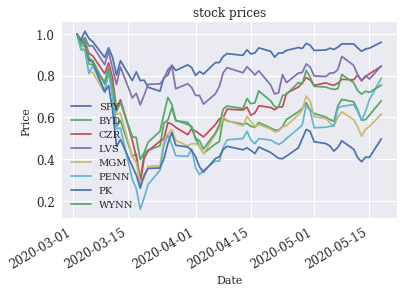

In [222]:
def plot_df(df, title='stock prices'):
    
    ax = df.plot(title=title, fontsize=12)
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    plt.show()
    
    
plot_df(df_norm)

In [145]:
# resample by week
df_adj_closed.resample('1w', label='right').last().head()

,SPY,BYD,CZR,LVS,MGM,PENN,PK,WYNN
2020-03-08,295.721069,22.33,11.09,53.786976,20.24,23.91,15.446553,94.029999
2020-03-15,267.745575,15.34,8.49,48.051395,15.44,15.47,8.833379,72.519997
2020-03-22,228.800003,11.60,5.45,43.310001,9.11,7.89,6.356997,51.970001
2020-03-29,253.419998,15.30,6.85,42.099998,12.19,11.77,8.340000,63.310001
2020-04-05,248.190002,11.22,6.28,37.919998,10.58,9.77,6.040000,48.500000


In [45]:
def train_valid_data(df):
    
    # splitting into train and validation
    row = int(df.shape[0] * 0.8)
    train = df[:row]
    valid = df[row:]
    return train,valid

train, valid = train_valid_data(get_data(['PK']))

In [46]:
# shapes of training set
print('\n Shape of training set:')
print(train.shape)

# shapes of validation set
print('\n Shape of validation set:')
print(valid.shape)


 Shape of training set:
(201, 1)

 Shape of validation set:
(51, 1)


In [47]:
def predict_moving_average(df):
    
    train = train_valid_data(df)[0]
    preds = []
    for i in range(0,valid.shape[0]):
        a = train['adj_close'][len(train)-50+i:].sum() + sum(preds)
        b = a/50
        preds.append(b)
        
    return preds

def RMSE(preds, actual):
    rmse = np.sqrt(np.mean(np.power((np.array(actual)-preds),2)))
    return rmse

####function test#####
df = get_data(['PK'])
train, valid = train_valid_data(df)
preds = predict_moving_average(train)

rmse_pk = RMSE(preds, valid)

In [49]:
rmse_pk

14.796990895251978

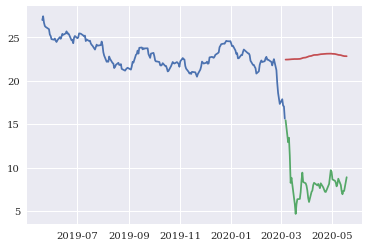

In [48]:
#plot
def plot_rmse_MA(df):
    
    train, valid = train, valid = train_valid_data(df)
    valid['predictions'] = predict_moving_average(train)
    plt.plot(train['adj_close'])
    plt.plot(valid[['adj_close', 'predictions']])
    
df = get_data(['PK'])
plot_rmse_MA(get_data(['PK']))

## Conclusion:

In general regression methods that take into account indepent features such as KNN, Linear Regression won't perform really well.

Moving Average is also too simplistic because it is simply summarizing neighborly data without capturing more nuanced pattern.

## Time Series Method

> So we will use auto ARIMA which automatically selects the best combination of (p,q,d) that provides the least error.

[predicting stock prices](https://www.analyticsvidhya.com/blog/2018/10/predicting-stock-price-machine-learningnd-deep-learning-techniques-python/?#)

In [5]:
from pyramid.arima import auto_arima

df = get_data(['PK'])
data = df.sort_index(ascending=True, axis=0)

train_num = int(len(data)*0.8)
train = data[:train_num]
valid = data[train_num:]

training = train['adj_close']
validation = valid['adj_close']

model = auto_arima(training, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, 
                   seasonal=True,d=1, D=1, trace=True,error_action='ignore',suppress_warnings=True)
model.fit(training)

forecast = model.predict(n_periods=51)
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=196.022, BIC=212.204, Fit time=0.871 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=280.769, BIC=287.242, Fit time=0.156 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=225.962, BIC=238.908, Fit time=0.463 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=198.121, BIC=211.066, Fit time=0.832 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=197.931, BIC=217.349, Fit time=1.247 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=261.922, BIC=274.868, Fit time=0.462 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=197.926, BIC=217.344, Fit time=3.615 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=199.861, BIC=222.516, Fit time=5.495 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=197.454, BIC=216.872, Fit time=1.445 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 

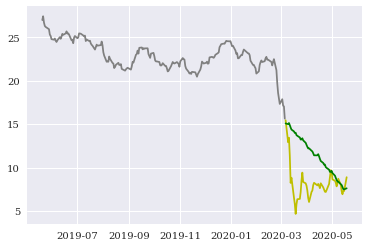

In [6]:
#plot
plt.plot(train['adj_close'], color='grey')
plt.plot(valid['adj_close'], color='y')
plt.plot(forecast['Prediction'], color='green')

ARIMA certainly improves because the the predicted values certainly follows the trend of the actual values.

In [10]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

Using TensorFlow backend.


In [11]:
def get_scaler():
    
    return MinMaxScaler(feature_range=(0, 1))

In [12]:
scaler_obj = get_scaler()

In [17]:
def train_lstm(tick_name, scaler_obj, timestep=10, epochs=20):
    
    # get data series
    df_tick = get_data([tick_name])
    dataset_tick = df_tick.values
    
    # split into train and test
    num_train = int(len(dataset_tick) * 0.8)
    train_tick = dataset_tick[0:num_train, :]
    valid_tick = dataset_tick[num_train:, :]
    
    # scale the data
    scaled_tick_data = scaler_obj.fit_transform(dataset_tick)
    
    # make training data for LSTM model
    x_tick_train, y_tick_train = [], []
    for i in range(timestep, len(train_tick)):
        x_tick_train.append(scaled_tick_data[i-timestep:i,0])
        y_tick_train.append(scaled_tick_data[i,0])
        
    x_tick_train, y_tick_train = np.array(x_tick_train), np.array(y_tick_train)

    x_tick_train = np.reshape(x_tick_train, (x_tick_train.shape[0], x_tick_train.shape[1], 1))
    
    # create and fit the LSTM network
    model_tick = Sequential()
    model_tick.add(LSTM(units=32, return_sequences=True, input_shape=(x_tick_train.shape[1],1)))
    model_tick.add(LSTM(units=16))
    model_tick.add(Dense(1))

    model_tick.compile(loss='mean_squared_error', optimizer='adam')
    model_tick.fit(x_tick_train, y_tick_train, batch_size=1, epochs=epochs, verbose=2)
    
    return model_tick

In [14]:
model_pk = train_lstm('PK', scaler_obj, timestep=10)

Epoch 1/20
 - 4s - loss: 0.0272
Epoch 2/20
 - 2s - loss: 0.0039
Epoch 3/20
 - 2s - loss: 0.0032
Epoch 4/20
 - 2s - loss: 0.0029
Epoch 5/20
 - 3s - loss: 0.0026
Epoch 6/20
 - 2s - loss: 0.0025
Epoch 7/20
 - 3s - loss: 0.0022
Epoch 8/20
 - 2s - loss: 0.0023
Epoch 9/20
 - 2s - loss: 0.0025
Epoch 10/20
 - 2s - loss: 0.0021
Epoch 11/20
 - 2s - loss: 0.0023
Epoch 12/20
 - 3s - loss: 0.0020
Epoch 13/20
 - 3s - loss: 0.0018
Epoch 14/20
 - 3s - loss: 0.0019
Epoch 15/20
 - 3s - loss: 0.0019
Epoch 16/20
 - 2s - loss: 0.0015
Epoch 17/20
 - 2s - loss: 0.0019
Epoch 18/20
 - 3s - loss: 0.0016
Epoch 19/20
 - 3s - loss: 0.0012
Epoch 20/20
 - 3s - loss: 0.0013


In [15]:
model_pk.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10, 32)            4352      
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 7,505
Trainable params: 7,505
Non-trainable params: 0
_________________________________________________________________


In [78]:
# scaler_pk = MinMaxScaler(feature_range=(0, 1))
# scaled_pk_data = scaler_pk.fit_transform(dataset_pk)

In [82]:
# x_pk_train, y_pk_train = [], []
# for i in range(10,len(train_pk)):
#     x_pk_train.append(scaled_pk_data[i-10:i,0])
#     y_pk_train.append(scaled_pk_data[i,0])
# x_pk_train, y_pk_train = np.array(x_pk_train), np.array(y_pk_train)

# x_pk_train = np.reshape(x_pk_train, (x_pk_train.shape[0], x_pk_train.shape[1], 1))

In [16]:
x_pred_pk = prep_past_data('PK', scaler_obj, 10)

NameError: name 'prep_past_data' is not defined

In [18]:
def prep_past_data(tick_name, scaler_obj, timestep=10):
    
    #get data series
    df_tick = get_data([tick_name])
    dataset_tick = df_tick.values
    
    num_valid = len(dataset_tick)-int(len(dataset_tick) * 0.8)
    inputs = df_tick[len(dataset_tick) - num_valid - timestep:].values
    inputs = inputs.reshape(-1,1)
    inputs  = scaler_obj.transform(inputs)

    X_pred_tick = []
    for i in range(timestep,inputs.shape[0]):
        X_pred_tick.append(inputs[i-timestep:i,0])
        
    X_pred_tick = np.array(X_pred_tick)

    X_pred_tick = np.reshape(X_pred_tick, (X_pred_tick.shape[0], X_pred_tick.shape[1],1))
    
    return X_pred_tick

def lstm_predict(X_pred_tick, model_tick, scaler_obj, next_n_days):
    # make prediction
    closing_prices = model_tick.predict(X_pred_tick)
    closing_prices = scaler_obj.inverse_transform(closing_prices)
    
    return closing_prices[:next_n_days]

In [19]:
x_pred_pk = prep_past_data('PK', scaler_obj, 10)

In [20]:
closing_pk_prices = lstm_predict(x_pred_pk, model_pk, scaler_obj, next_n_days=20)

In [21]:
closing_pk_prices

array([[17.578123 ],
       [17.093906 ],
       [16.222164 ],
       [15.498902 ],
       [14.584112 ],
       [13.274307 ],
       [12.167206 ],
       [10.971357 ],
       [ 9.854607 ],
       [ 8.797442 ],
       [ 8.07328  ],
       [ 7.668316 ],
       [ 7.479249 ],
       [ 7.5101094],
       [ 7.822025 ],
       [ 8.353646 ],
       [ 8.737299 ],
       [ 8.987075 ],
       [ 9.089139 ],
       [ 9.032316 ]], dtype=float32)

In [194]:
df_tick = get_data(['PENN'])
dataset_tick = df_tick.values
num_valid = len(dataset_tick)-int(len(dataset_tick) * 0.8)
len(dataset_tick) - num_valid - 10

191

In [195]:
len(closing_penn_prices)

51

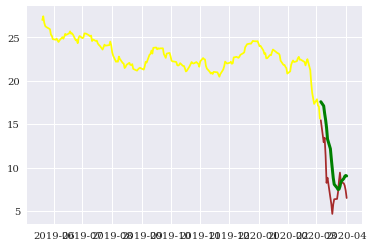

In [23]:
#for plotting

def plot_predicted_prices(tick_name, closing_tick_prices):

    df_tick = get_data([tick_name])
    train_tick = df_tick[:int(df_tick.shape[0] * 0.8)]
    valid_tick = df_tick[int(df_tick.shape[0] * 0.8):][:len(closing_tick_prices)]

    
    ax = plt.gca()

    valid_tick['predictions'] = closing_tick_prices
    plt.plot(train_tick['adj_close'], color = 'yellow')
    plt.plot(valid_tick['adj_close'], color = 'brown')
    plt.plot(valid_tick['predictions'], color = 'green', linewidth=3)
    
plot_predicted_prices('PK', closing_pk_prices)

In [66]:
def normalize_data(df):
    return df/df.iloc[0]

ax = df_norm['SPY'].plot(title='rolling mean', label='SPY')
rm_spy = df_norm['SPY'].rolling(20).mean() 
rm_spy.plot(title='rolling mean', ax=ax)

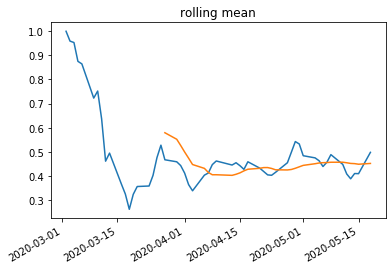

In [87]:
ax = df_norm['PK'].plot(title='rolling mean', label='PK')
rm_pk = df_norm['PK'].rolling(20).mean() 
rm_pk.plot(title='rolling mean', ax=ax)

In [96]:
def compute_daily_returns(df):
    
    daily_returns = df.copy()
    daily_returns = (df/df.shift(1)) - 1
    
    return daily_returns

daily_return_pk = compute_daily_returns(df['PK'])
daily_return_spy = compute_daily_returns(df['SPY'])

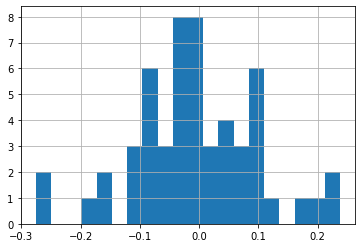

In [101]:
daily_return_pk.hist(bins=20)

In [102]:
# get mean and std

mean_pk = daily_return_pk.mean()
std_pk = daily_return_pk.std()
mean_pk, std_pk

(-0.007162501540953116, 0.10603779538338332)

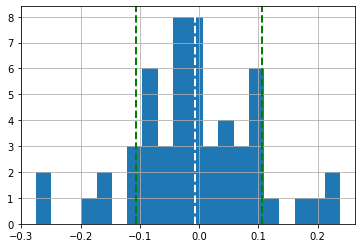

In [108]:
daily_return_pk.hist(bins=20)
plt.axvline(mean_pk, color='w', linestyle='dashed', linewidth=2)
plt.axvline(-std_pk, color='green', linestyle='dashed', linewidth=2)
plt.axvline(std_pk, color='green', linestyle='dashed', linewidth=2)
plt.show()

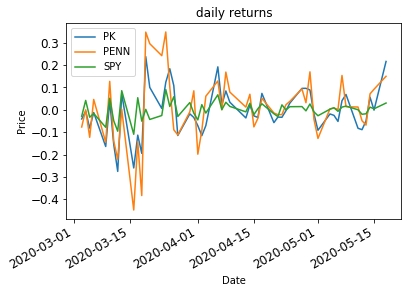

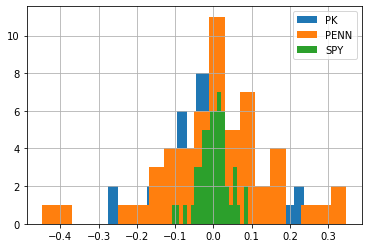

In [127]:
data = get_data(['PK', 'PENN', 'SPY'])
#plot_df(data)
daily_returns = compute_daily_returns(data)
plot_df(daily_returns, title='daily returns')

# compute and plot two histograms on the same chart
daily_returns['PK'].hist(bins=20, label='PK')
daily_returns['PENN'].hist(bins=20, label='PENN')
daily_returns['SPY'].hist(bins=20, label='SPY')
plt.legend(loc='upper right')
plt.show()


,PK,PENN,SPY
PK,1.000000,0.807704,0.681019
PENN,0.807704,1.000000,0.551131
SPY,0.681019,0.551131,1.000000


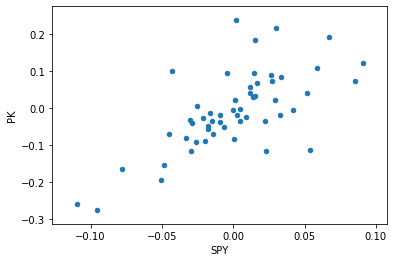

In [136]:
daily_returns.plot(kind='scatter', x='SPY', y='PK')
#np.polyfit(daily_returns['SPY'], daily_returns['PENN'])
daily_returns.corr(method='pearson')

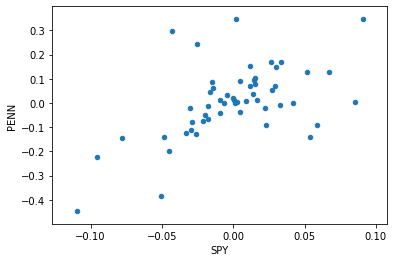

In [129]:
daily_returns.plot(kind='scatter', x='SPY', y='PENN')